In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt

from time_series_experiments import utils
from time_series_experiments.utils import metrics
from time_series_experiments.utils import scalers
from time_series_experiments import baseline
from time_series_experiments import nbeats

tf.get_logger().setLevel('ERROR')

In [2]:
seed = 0xC0FFEE
fdw = 168
fw = 24

temp_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv')

In [3]:
y = temp_df['Temp'].values

x_train_idx, y_train_idx, x_test_idx, y_test_idx = utils.train_test_split_index(
    y.shape[0], fdw, fw, test_size=0.1, random_seed=seed, shuffle_train=False
)

x_train = np.expand_dims(y[x_train_idx], axis=-1)
y_train = y[y_train_idx]
x_test = np.expand_dims(y[x_test_idx], axis=-1)
y_test = y[y_test_idx]

In [4]:
baseline_model = baseline.LatestNaiveBaseline(fw=fw)
y_pred_baseline = baseline_model.predict(x_test)
print('RMSE', metrics.rmse(y_test, y_pred_baseline))

RMSE 3.644566467263221


In [5]:
scaler = scalers.MeanScaler()

xtr = scaler.fit_transform(x_train)
ytr = scaler.transform(y_train)

model = nbeats.NBEATS(
    fdw=fdw,
    fw=fw,
    stacks=[
        nbeats.StackDef(
            nbeats.StackTypes.NBEATS_DRESS,
            block_types=[nbeats.BlockTypes.SEASONAL, nbeats.BlockTypes.GENERIC],
            block_units=16,
            block_theta_units=16,
            block_layers=4,
        )
    ]
)
model.compile(loss='mae', optimizer=keras.optimizers.Adam(0.01))
history = model.fit(
    xtr, 
    ytr, 
    batch_size=8, 
    epochs=100, 
    verbose=False,
    validation_split=0.1
)

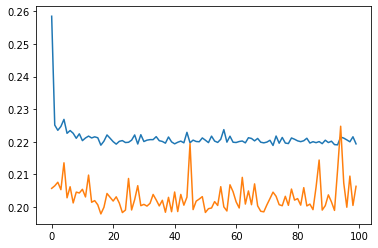

In [6]:
plot_y1 = np.array(history.history['loss'])
plot_y2 = np.array(history.history['val_loss'])
plot_x = np.arange(plot_y1.shape[0])
plt.plot(plot_x, plot_y1)
plt.plot(plot_x, plot_y2)

In [7]:
scaler = scalers.MeanScaler()
xt = scaler.fit_transform(x_test)

y_pred = model.predict(xt)
y_pred = scaler.inverse_transform(y_pred)

print('RMSE', metrics.rmse(y_test, y_pred)) 
print('MASE', metrics.mase(y_test, y_pred, y_pred_baseline))

RMSE 2.901866011554205
MASE 0.7850897613180207


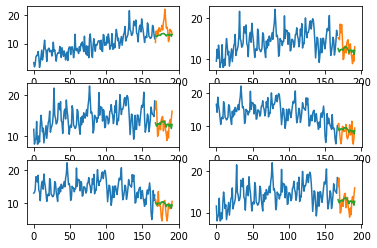

In [8]:
fig, axes = plt.subplots(3, 2)
axes = [item for sublist in axes for item in sublist]

indexes = np.random.choice(np.arange(y_pred.shape[0]), len(axes))

for i, ax in zip(indexes, axes): 
    plot_x = np.squeeze(x_test[i])
    plot_y_pred = np.squeeze(y_pred[i])
    plot_y = np.squeeze(y_test[i])
    
    plot_x_numbers = np.arange(0, plot_x.shape[0])
    plot_y_numbers = np.arange(plot_x.shape[0], plot_x.shape[0] + plot_y.shape[0])

    ax.plot(plot_x_numbers, plot_x)
    ax.plot(plot_y_numbers, plot_y)
    ax.plot(plot_y_numbers, plot_y_pred)